In [1]:
import os
from collections import defaultdict
from datetime import datetime
import copy

from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})
%matplotlib inline

import plotly
import plotly.graph_objs as pgo

from nxplot_3d import get_trace_nodes_3D_legend
from nxplot_3d import get_trace_edges_3D
from nxplot_3d import plot_3D

from export_import import export_data
from export_import import read_data

from csv_to_network import get_graph

In [2]:
path= '../data/dynamic/'
file_names =  sorted(os.listdir(path), key=lambda x: datetime.strptime(x, '%Y-%m.csv'))
data = pd.DataFrame(columns=['package', 'requirement', 'time'])

for i, fname in enumerate(file_names):
    dframe_load = pd.read_csv(path+ fname, sep='|', keep_default_na=False)
    dframe_load = dframe_load.assign(time=[fname[:-4] for _ in range(len(dframe_load))])
    data = pd.concat([data, dframe_load], ignore_index=True)
    

In [3]:
class TDiGraph(nx.DiGraph):
    def __init__(self, all_edges:pd.DataFrame):
        self.t = 0
        
        self.all_edges = all_edges
        self.all_nodes = all_edges.drop_duplicates(subset=self.all_edges.keys()[0], ignore_index=True)
        
        self.time_edges = self.all_edges['time']
        self.time_nodes = self.all_nodes['time']
        self.time_steps = sorted(list(set(self.time_nodes)), key=lambda x: datetime.strptime(x, '%Y-%m'))
        
        super(TDiGraph, self).__init__()
    
    def __str__(self):
        return f'TDiGraph with {self.number_of_nodes()} nodes and {self.number_of_edges()} edges at time {self.t}'
    
    def __repr__(self):
        return 'time extention of networkx.classes.digraph.DiGraph'
        
    def forward(self):
        if self.t <= len(self.time_steps):
            self.add_edges_from(zip(self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,0],\
                                       self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,1]))
            self.remove_nodes_from([''])
            self.t += 1
        else:
            raise GeneratorError(f'Max t={len(self.time_steps) + 1} reached')
            
    
    def backward(self):
        if self.t != 0:
            self.t -= 1
            self.remove_edges_from(zip(self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,0],\
                                       self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,1]))
            self.remove_nodes_from([''])
        else:
            raise GeneratorError('Time t=0 reached')


In [4]:
def tdg_draw(TDG, posDG3D=None, fname=None, auto_open=True, path='../plots/dynamic/'):
    max_deg = max(TDG.degree(), key=lambda x: x[1])[1]
    if max_deg == 0:
        max_deg = 1
    if posDG3D == None:
        posDG3D = nx.spring_layout(TDG, dim=3, k=1/np.sqrt(TDG.number_of_nodes())*10)
    if fname == None:
        fname = str(TDG.time_steps[TDG.t])
    cmap = cm.get_cmap('Reds', 2)
    export_data(TDG, posDG3D, cmap, path='../nodes_edges/dynamic/', step=TDG.t, max_deg=max_deg)
    G, d_hoverinfo, d_nodecolors, d_nodesize, posG3D = read_data(f'../nodes_edges/dynamic/nodes_{TDG.t}.csv',
                                                                 f'../nodes_edges/dynamic/edges_{TDG.t}.csv')
    node_trace = get_trace_nodes_3D_legend(posG3D, d_hoverinfo, d_nodecolors, d_nodesize)
    edge_trace = get_trace_edges_3D(G, posG3D, color = '#C7C7C7', opac = 0.2, linewidth=0.5)
    data = [*node_trace, edge_trace]
    plot_3D(data, path=path, fname=fname, scheme='dark', auto_open=auto_open)

def get_growth(TDG, k_i_t:dict):
    add_degrees = TDG.in_degree
    k_i_t.update({node: [*k_i_t[node], int(deg)] for node, deg in add_degrees})
    return k_i_t

# Growth Exponent

In [125]:
TDG = TDiGraph(data)
k_i_t = {node: [] for node in TDG.all_nodes.iloc[:,0]}
for i in range(len(TDG.time_steps)):
    TDG.forward()
    get_growth(TDG, k_i_t)

In [126]:
k_i_t = sorted(list(k_i_t.items()), key=lambda x: max(x[1]), reverse=True)

/tmp/ipykernel_9964/3269217411.py:16: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_9964/3269217411.py:16: RuntimeWarning:

divide by zero encountered in log



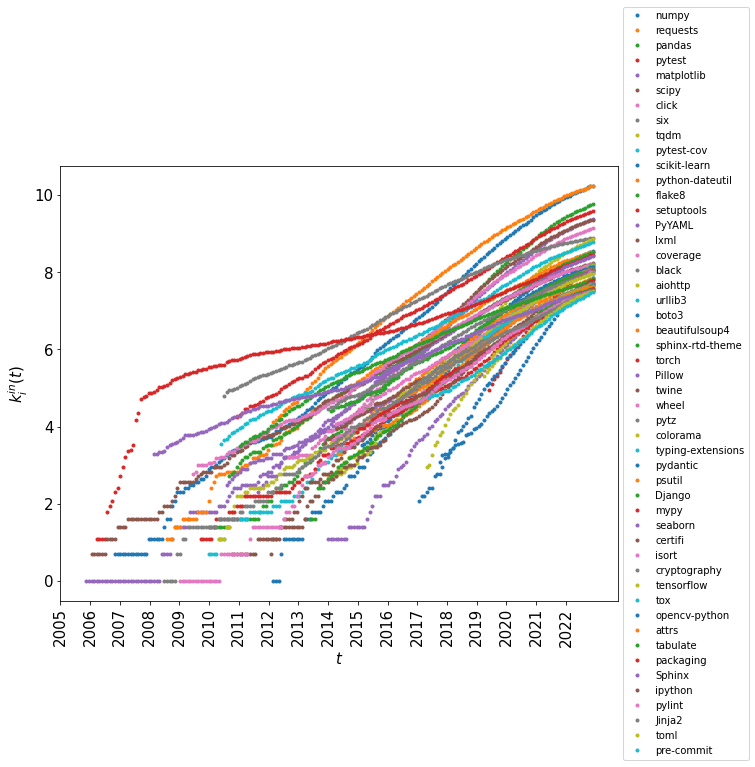

In [160]:
def fit_lin(x, β, B):
    return β * x + B 

time_steps = len(TDG.time_steps)
years = sorted(list(set([date[:4] for date in TDG.time_steps])), key=lambda x: datetime.strptime(x, '%Y'))
fig, ax = plt.subplots(1, 1, figsize=[10, 8])
cmap = cm.get_cmap('tab10').colors
j=0
β_i = {}

for node, k_i in [k_i_t[i] for i in range(len(k_i_t)) if max(k_i_t[i][1]) > 5 and len(k_i_t[i][1]) > 10]:
#    try:
    if j < 50:
        time_creation = time_steps - len(k_i)
        time_seq = np.arange(time_creation, time_steps)
        log_k_i = np.log(k_i)
        #popt, pcov = curve_fit(fit_lin, time_seq, log_k_i)
        ax.plot(time_seq, np.log(k_i, where=(np.array(k_i)>0)), '.', label=node)
        j+=1
        β_i[node] =  popt[0]
#    except:
        #continue
    

ax.set_xticks([time_steps/len(years)*i for i in range(len(years))])
ax.set_xticklabels(years, rotation='vertical', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel(r'$t$', fontsize=15)
ax.set_ylabel(r'$k^{in}_i(t)$', fontsize=15)
fig.savefig('../pres/pics/edge_growth.png', dpi=300)

[5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6]

/tmp/ipykernel_2109/3225311740.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(ϱ_η[1][1:], np.log(ϱ_η[0]/sum(ϱ_η[0])), 'o', label='stretched exponential')


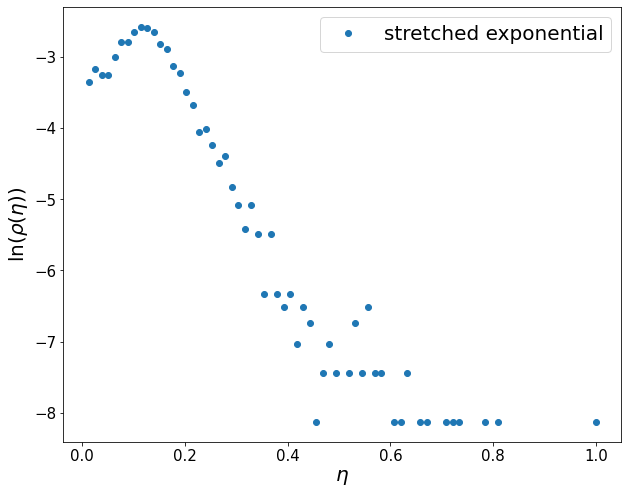

In [8]:
lβ = list(β_i.values())
ϱ_η = np.histogram(lβ/max(lβ), bins='auto')
fig, ax = plt.subplots(1, 1, figsize=[10, 8])
ax.plot(ϱ_η[1][1:], np.log(ϱ_η[0]/sum(ϱ_η[0])), 'o', label='stretched exponential')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel(r'$\ln(\rho(\eta))$', fontsize=20)
ax.set_xlabel(r'$\eta$', fontsize=20)
ax.legend(loc='best', fontsize=20)
fig.savefig('../pres/pics/fitness.png', dpi=300)

# Node Growth

In [9]:
TDG = TDiGraph(data)
n_nodes = []
k_max = []
for i in range(len(TDG.time_steps)-1):
    TDG.forward()
    n_nodes.append(TDG.number_of_nodes())
    k_max.append(max(list(TDG.degree()), key=lambda x:x [1])[1])

[Text(0.0, 0, '2005'),
 Text(11.38888888888889, 0, '2006'),
 Text(22.77777777777778, 0, '2007'),
 Text(34.16666666666667, 0, '2008'),
 Text(45.55555555555556, 0, '2009'),
 Text(56.94444444444444, 0, '2010'),
 Text(68.33333333333334, 0, '2011'),
 Text(79.72222222222223, 0, '2012'),
 Text(91.11111111111111, 0, '2013'),
 Text(102.5, 0, '2014'),
 Text(113.88888888888889, 0, '2015'),
 Text(125.27777777777779, 0, '2016'),
 Text(136.66666666666669, 0, '2017'),
 Text(148.05555555555557, 0, '2018'),
 Text(159.44444444444446, 0, '2019'),
 Text(170.83333333333334, 0, '2020'),
 Text(182.22222222222223, 0, '2021'),
 Text(193.61111111111111, 0, '2022')]

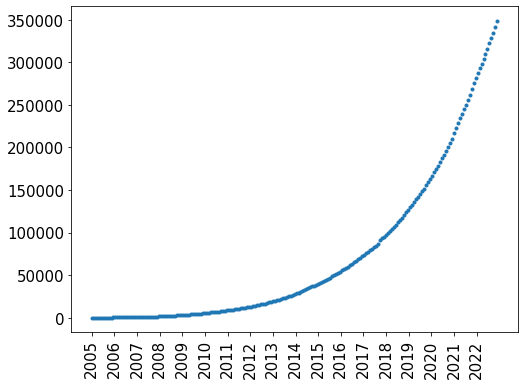

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.plot(n_nodes, '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks([len(n_nodes)/len(years)*i for i in range(len(years))])
ax.set_xticklabels(years, rotation='vertical')

# Preferential Attachment

In [11]:
Π_i = []
deg = []
α_i = {}
ᾱ = 0; σ_α = 0
j = 0
for node, k_i in [k_i_t[i] for i in range(len(k_i_t)) if max(k_i_t[i][1]) > 10 and len(k_i_t[i][1]) > 10]:
    try:
        π_k = np.cumsum(np.gradient(k_i, 1))
        popt, pcov = curve_fit(fit_lin, k_i, π_k)
        if popt[0] < 0:
            continue
        α_i[node] = popt[0]
        ᾱ += popt[0] ; σ_α += np.sqrt(pcov[0, 0])
        j += 1
    except:
        continue
ᾱ = ᾱ/j; σ_α +=  σ_α/j

/home/miksa/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# 3D Light ray layout

In [12]:
TDG = TDiGraph(data)
for i in range(len(TDG.time_steps)-1):
    TDG.forward()
TDG.remove_nodes_from([node for node, degree in TDG.in_degree if degree < 50])

In [5]:
def random_in_circle(R):
    ϕ = np.random.uniform(0, R) * 2 * np.pi
    r = np.sqrt(np.random.uniform(0, R))
    x = r * np.cos(ϕ)
    y = r * np.sin(ϕ)
    return x, y

def ray_layout(TDG):
    degree = list(dict(TDG.degree).values())
    dist, layers = np.histogram(degree, bins='sqrt')
    posDG3D = {}
    for n, k in TDG.degree:
        for i in range(len(layers)-1):
            if k <= layers[i+1]:
                x, y = random_in_circle(dist[i]/2)
                z = np.sqrt(i)
                posDG3D[n] = [x, y, z]
                break
    return posDG3D

In [16]:
TDG = TDiGraph(data)
for i in range(len(TDG.time_steps)-100):
    TDG.forward()
    
TDG.remove_nodes_from([node for node, degree in TDG.in_degree if degree < 10])
posDG3D = ray_layout(TDG)
tdg_draw(TDG, posDG3D, fname='sqrt')

Opening in existing browser session.


# Configuration for VR

Since the VR-lab cannot take time varying networks where nodes get deleted we have to kind of 
shuffle through them without removing them but repositioning them somwhere where they cannnot be 
seen. This is done by saving the layout of the nodes at the last time step and then iterating 
backwards, after each step moving nodes that are not in timestep (t-1) somewhere else and removing 
all their edges. Additionally for the story we have to choose one node and following its history 
paiting it a color, e.g. red. The procedere will go as follows

    1. save a nice layout at time $t=T$ (last step)
    2. choose a node/package to follow
    3. check creation date of node, call it $T_0$
    4. iterate from (t=T to t=T_0, t--);
           1. move nodes not present in t-1 to a coordinate system edge e.g $(-1,-1,-1)$
           2. remove edges of all moved nodes.
           3. save layout.

Choosing 'seaborn' as package to follow is in my perspective usefull. 

In [7]:
TDG = TDiGraph(data)
for i in range(len(TDG.time_steps)):
    TDG.forward()
    
TDG.remove_nodes_from([node for node, degree in TDG.in_degree if degree < 10])
posDG3D = ray_layout(TDG)

choosen_package = 'seaborn'
date_current = data['time'].iloc[-1]
date_creation = data[data['package'] == choosen_package]['time'].iloc[0]
T_0 =  (int(date_current[:4]) - int(date_creation[:4]))*12 \
                +int(date_current.split('-')[1]) - int(date_creation.split('-')[1])  - 1

#tdg_draw(TDG, posDG3D, fname=f'{date_current}', path='../plots/vr/')
cmap = cm.get_cmap('Reds', 2)
max_deg = 
max(TDG.degree, key = lambda x: x[1])[1]

export_data(TDG, posDG3D, cmap, path='../nodes_edges/vr/', step=TDG.time_steps[TDG.t-1], max_deg=max_deg)


for i in range(T_0):
    nodes_to_move = list(set(TDG.all_nodes[TDG.time_nodes == TDG.time_steps[TDG.t-1]]['package'].to_list()).intersection(TDG.nodes))
    for node in nodes_to_move:
        posDG3D[node] = [0, 0, -1]
    export_data(TDG, posDG3D, cmap, path='../nodes_edges/vr/', step=TDG.time_steps[TDG.t-1], max_deg=max_deg)
    TDG.t -= 1

NameError: name 'max_deg' is not defined

668